In [1]:
using Pkg; Pkg.activate("."); Pkg.instantiate()
using LinearAlgebra
using PyPlot
using ControlSystems
import ForwardDiff as FD

  Activating project at `~/OCRL/RL`


In [2]:
#1D Double-Integrator Problem
N = 15
n = 2
m = 1
x0 = [1.0; 0]
u0 = 0.0
dt = 1.0
A = [1 dt; 0 1];
B = [0.5*dt*dt; dt];
gamma = 0.95

0.95

In [3]:
#LQR Cost Matrices
P = Array(1.0*I(2))
R = Array(0.1*I(1))
#Pf = Array(1.0*I(2));
Pf = dare(A,B,P,R); #This makes sure that the infinite-horizon K is the solution to the finite-horizon problem

In [4]:
#Cost Function
function cost(xtraj,utraj,P,R,Pf)
    J = 0.0
    for k = 1:(N-1)
        J += 0.5*xtraj[:,k]'*P*xtraj[:,k] + 0.5*(utraj[k]'*R*utraj[k])[1]
    end
    J += 0.5*xtraj[:,N]'*Pf*xtraj[:,N]
end

function cost!(xtraj,utraj,P,R,Pf, cost_batch)
    J = 0.0
    for k = 1:(N-1)
        cost_batch[k] = 0.5*xtraj[:,k]'*P*xtraj[:,k] + 0.5*(utraj[k]'*R*utraj[k])[1]
    end
    cost_batch[N] = 0.5*xtraj[:,N]'*Pf*xtraj[:,N]
end

function Q_func(xi, ui, Qxx, Qux, Quu)
    Q_val = 0.5*ui*Quu*ui + (xi'*Qux*ui)[1] + 0.5*xi'*Qxx*xi
    return Q_val
end

function Q_func_grad(xi, ui, Q_vec)
    uivec = [ui]
    Lxx, Luu, Qux = get_Ls(Q_vec)
    Luu_grad = reshape(Luu*uivec*uivec', m*m)
    Qux_grad = reshape(xi*uivec', n*m)
    Lxx_grad = reshape(Lxx*xi*xi', n*n)
    Q_grad = vcat([Lxx_grad; Qux_grad; Luu_grad])
    return Q_grad
end    

function Q_func_argmin(xi, Q_vec)
    Qxx, Qux, Quu = get_Qs(Q_vec)
    u_min = (-xi'*Qux/(Quu[1,1]))
    Q_min = Q_func(xi, u_min[1], Qxx, Qux, Quu[1,1])
    return u_min[1], Q_min
end

function bellman_residual(xi, ui, xi_1, costi, Qxx, Qux, Quu, Q_vec_targ)
    res = Q_func(xi, ui, Qxx, Qux, Quu[1,1]) - (costi + gamma*Q_func_argmin(xi_1, Q_vec_targ)[2])
    return res
end

bellman_residual (generic function with 1 method)

In [5]:
#Groud Truth Solution (Infinite-Horizon LQR Gain)
K_true = dlqr(A,B,P,R)

1×2 Matrix{Float64}:
 0.616695  1.27032

In [6]:
#Ground-truth Closed-loop simulation with LQR controller

function rollout!(xtraj,utraj,vtraj,x0, Q_vec,V,W)
    xtraj[:,1] .= x0
    for k = 1:(N-1)
        vtraj[k] = sqrt(V)*randn()
        u_opt = Q_func_argmin(xtraj[:, k], Q_vec)[1]
        utraj[k] = u_opt + vtraj[k]
        xtraj[:,k+1] .= A*xtraj[:,k] + B*utraj[k] + sqrt(W)*randn(2)
    end
end

function rollout!(xtraj,utraj,vtraj,x0, K)
    xtraj[:,1] .= x0
    for k = 1:(N-1)
        u_opt = -K*xtraj[:, k]
        utraj[k] = u_opt[1]
        xtraj[:,k+1] .= A*xtraj[:,k] + B*utraj[k]
    end
end

function compute_Q_grad(xtraj, utraj, costtraj, Q_vec, Q_vec_targ)
    Q_grad = zeros(n*n + n*m + m*m)
    Q_res = zeros(N-1)
    Qxx, Qux, Quu = get_Qs(Q_vec)
    for k = 1:(N-1)
        Q_res[k] = bellman_residual(xtraj[:,k], utraj[k], xtraj[:,k+1], costtraj[k], Qxx, Qux, Quu, Q_vec_targ)
        Q_gradk = Q_func_grad(xtraj[:,k], utraj[k], Q_vec)
        Q_grad[:] .+= Q_gradk*Q_res[k]
    end
    return Q_grad, Q_res
end

function get_Qs(Q_vec)
    Lxx = reshape(Q_vec[1:n*n], n, n)
    Qxx = Lxx'*Lxx
    Qux = reshape(Q_vec[n*n+1:n*n+n*m], n, m)
    Luu = reshape(Q_vec[n*n+n*m+1:end], m, m)
    Quu = Luu'*Luu
    return Qxx, Qux, Quu
end

function get_Ls(Q_vec)
    Lxx = reshape(Q_vec[1:n*n], n, n)
    Qux = reshape(Q_vec[n*n+1:n*n+n*m], n, m)
    Luu = reshape(Q_vec[n*n+n*m+1:end], m, m)
    return Lxx, Luu, Qux
end


xtraj_true = zeros(n,N)
utraj_true = zeros(N-1)
vtraj_true = zeros(N-1)

rollout!(xtraj_true,utraj_true,vtraj_true,x0,K_true)

In [7]:
function get_Q_vec(K)
    D = P + K'*R*K
    M = zeros(n,n)
    M .+= D*gamma
    S = A - B*K
    Si = S*gamma*gamma
    for i=1:100
        M .+= Si'*D*Si
        Si = Si*S*gamma
    end
    Qxx = P + A'*M*A
    Quu = R + [B'*M*B]
    Qux = A'*M*B
    Lxx = reshape(sqrt(Qxx), n*n)
    Luu = reshape(sqrt(Quu), m*m)
    Qux = reshape(Qux, n*m)
    Q_vec = vcat([Lxx; Qux; Luu])
    return Q_vec
end

get_Q_vec (generic function with 1 method)

cost(xtraj_true, utraj_true, P, R, Pf) = 1.0299384521582335


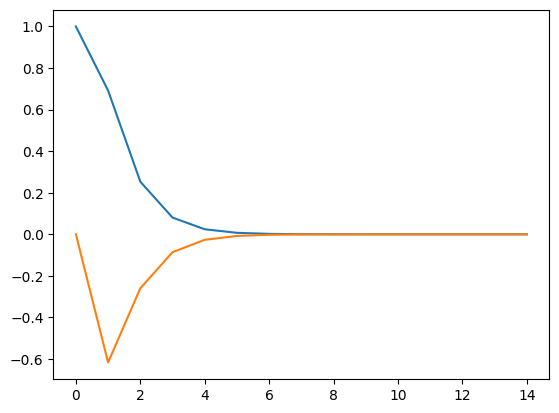

1.0299384521582335

In [8]:
plot(xtraj_true[1,:])
plot(xtraj_true[2,:])
@show cost(xtraj_true,utraj_true,P,R,Pf)

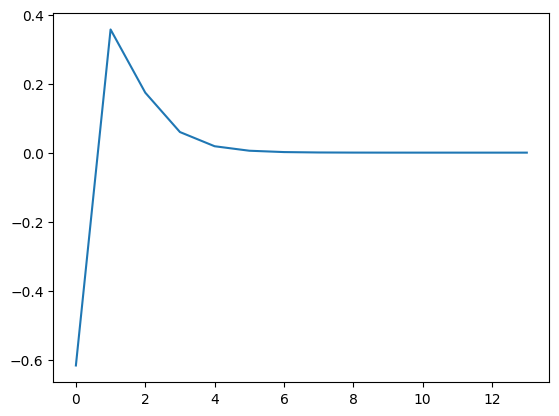

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f711168b8d0>

In [9]:
plot(utraj_true)

In [41]:
#Q-Learning Algorithm
iter = 1000 #number of outer-loop iterations
batch_size = 50 #number of rollouts for Q-learning update

α0 = 0.01 #step size ("learning rate")
β1 = 0.9
β2 = 0.999
ϵ = 1e-8

V = 0.01 #noise covariance for policy ("exploration")
W = zeros(2,2) #noise covariance for dynamics (process noise)

iter_costs = zeros(iter)
batch_vxt = zeros(1,2,batch_size)

adam_m = zeros(n*n + n*m + m*m)
adam_v = zeros(n*n + n*m + m*m)

xtraj_pg = zeros(2,N)
utraj_pg = zeros(N-1)
vtraj_pg = zeros(N-1);

Q_vec = get_Q_vec(K_true) + randn(n*n + n*m + m*m)*0.4
Q_vec_targ = deepcopy(Q_vec)
Qxx, Qux, Quu = get_Qs(Q_vec)

batch_grads = zeros(n*n + n*m + m*m, batch_size)
batch_costs = zeros(N)
batch_res = zeros(N-1,batch_size)

14×50 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

In [42]:
#Adam
for k = 1:1000
    
    #Do a bunch of rollouts with epsilon greedy policy
    for j = 1:batch_size
        rollout!(xtraj_pg,utraj_pg,vtraj_pg,x0,Q_vec,V,W)
        cost!(xtraj_pg,utraj_pg,P,R,Pf, batch_costs)
        batch_grads_j, batch_res_j = compute_Q_grad(xtraj_pg, utraj_pg, batch_costs, Q_vec, Q_vec_targ)
        batch_res[:, j] .= batch_res_j
        batch_grads[:, j] .= batch_grads_j
    end
    
    #Aggregate gradients
    grad = zeros(n*n + n*m + m*m)
    for j = 1:batch_size
        grad += batch_grads[:,j]
    end
        
    #Take Adam step on Q_vec using gradient estimate
    adam_m = β1*adam_m + (1-β1)*grad
    adam_v = β2*adam_v + (1-β2)*(grad.*grad)
    
    α = α0*sqrt(1-β2^(k+1))/(1-β1^(k+1))
    
    Q_vec -= α*adam_m./(sqrt.(adam_v).+ϵ)
    Qxx, Qux, Quu = get_Qs(Q_vec)
    Q_vec_targ = Q_vec*0.05 + Q_vec_targ*0.95
    
    #Evaluate cost for plotting
    rollout!(xtraj_pg,utraj_pg,vtraj_pg,x0, Q_vec, 0,zeros(2,2))
    iter_costs[k] = cost(xtraj_pg,utraj_pg,P,R,Pf)
end

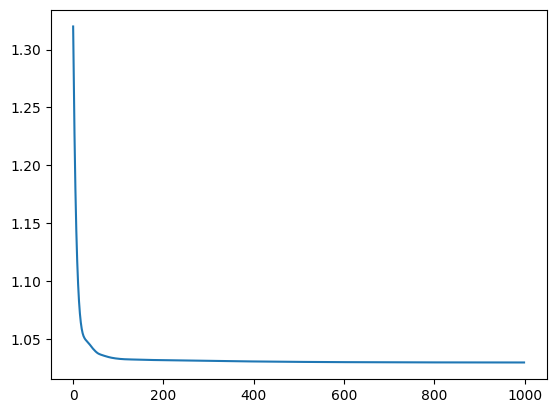

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f71103b3f98>

In [43]:
plot(iter_costs)

In [44]:
true_cost = cost(xtraj_true,utraj_true,P,R,Pf)

1.0299384521582335

In [45]:
iter_costs[end]

1.0299610974891849

In [46]:
Qxx, Qux, Quu = get_Qs(Q_vec)
Q_func(xtraj_pg[:,1], utraj_pg[1], Qxx, Qux, Quu[1,1])

0.9980742997393562

In [47]:
function discounted_cost(xtraj,utraj,Q,R,Qf)
    J = 0.0
    for k = 1:(N-1)
        J += (0.5*xtraj[:,k]'*Q*xtraj[:,k] + 0.5*(utraj[k]'*R*utraj[k])[1])*(gamma^(k-1))
    end
    J += 0.5*xtraj[:,N]'*Qf*xtraj[:,N]*(gamma^(N-1))
end
discounted_cost(xtraj_pg, utraj_pg,P,R,Pf)

1.0005542590697414

In [48]:
Q_vec_true = get_Q_vec(K_true)
Q_vec_true

7-element Vector{Float64}:
 1.5582106751697582
 0.6141977925199543
 0.6141977925199543
 2.169942248770182
 1.3871935777860347
 2.9409766433038147
 1.5321161360715438

In [49]:
Q_vec

7-element Vector{Float64}:
 1.5000285621723994
 0.869776091720707
 0.3919933335171369
 2.3418659809386044
 1.6282492492832261
 3.338399752339204
 1.619809723591103

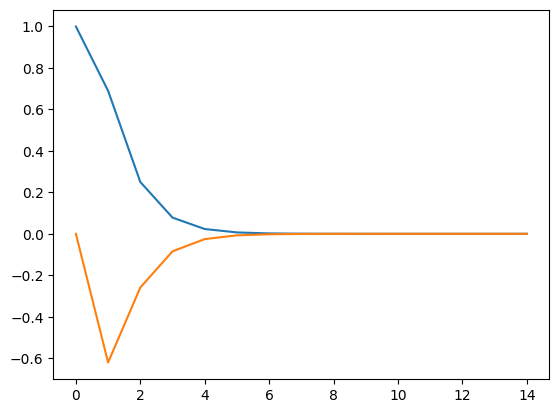

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f7111311080>

In [50]:
plot(xtraj_pg[1,:])
plot(xtraj_pg[2,:])

In [53]:
#Q-Learning Algorithm
iter = 1000 #number of outer-loop iterations
batch_size = 50 #number of rollouts for Q-learning update

α0 = 0.01 #step size ("learning rate")
β1 = 0.9
β2 = 0.999
ϵ = 1e-8

V = 0.01 #noise covariance for policy ("exploration")
W = zeros(2,2) #noise covariance for dynamics (process noise)

iter_costs = zeros(iter)
batch_vxt = zeros(1,2,batch_size)

adam_m = zeros(n*n + n*m + m*m)
adam_v = zeros(n*n + n*m + m*m)

xtraj_pg = zeros(2,N)
utraj_pg = zeros(N-1)
vtraj_pg = zeros(N-1);

Q_vec = get_Q_vec(K_true) + randn(n*n + n*m + m*m)
Q_vec_targ = deepcopy(Q_vec)
Qxx, Qux, Quu = get_Qs(Q_vec)

batch_grads = zeros(n*n + n*m + m*m, batch_size)
batch_costs = zeros(N)
batch_res = zeros(N-1,batch_size)

14×50 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

In [54]:
#Adam
for k = 1:1000
    
    #Do a bunch of rollouts with epsilon greedy policy
    for j = 1:batch_size
        rollout!(xtraj_pg,utraj_pg,vtraj_pg,x0,Q_vec,V,W)
        cost!(xtraj_pg,utraj_pg,P,R,Pf, batch_costs)
        batch_grads_j, batch_res_j = compute_Q_grad(xtraj_pg, utraj_pg, batch_costs, Q_vec, Q_vec_targ)
        batch_res[:, j] .= batch_res_j
        batch_grads[:, j] .= batch_grads_j
    end
    
    #Aggregate gradients
    grad = zeros(n*n + n*m + m*m)
    for j = 1:batch_size
        grad += batch_grads[:,j]
    end
        
    #Take Adam step on Q_vec using gradient estimate
    adam_m = β1*adam_m + (1-β1)*grad
    adam_v = β2*adam_v + (1-β2)*(grad.*grad)
    
    α = α0*sqrt(1-β2^(k+1))/(1-β1^(k+1))
    
    Q_vec -= α*adam_m./(sqrt.(adam_v).+ϵ)
    Qxx, Qux, Quu = get_Qs(Q_vec)
    Q_vec_targ = Q_vec*0.05 + Q_vec_targ*0.95
    
    #Evaluate cost for plotting
    rollout!(xtraj_pg,utraj_pg,vtraj_pg,x0, Q_vec, 0,zeros(2,2))
    iter_costs[k] = cost(xtraj_pg,utraj_pg,P,R,Pf)
end

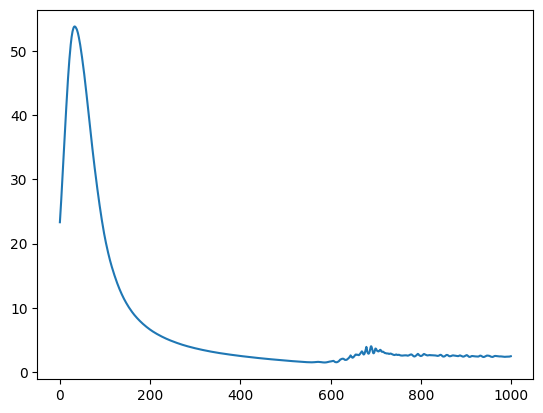

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f7110386c88>

In [55]:
plot(iter_costs)

In [56]:
iter_costs[end]

2.4621554758079114